<h1>Applied Data Science Lab3</h1>

<h2>Fraud Detection</h2>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (20, 12)

In [2]:
train_data_cols = ['transaction_id', 'client_id', 'transaction_value', 'merchant_id', 'date', 'time', 'fraud_flag']
train_data = pd.read_csv('transaction_one_base.csv', names=train_data_cols)
train_data.shape

(100000, 7)

<h3>Looking for patterns in transaction value</h3>

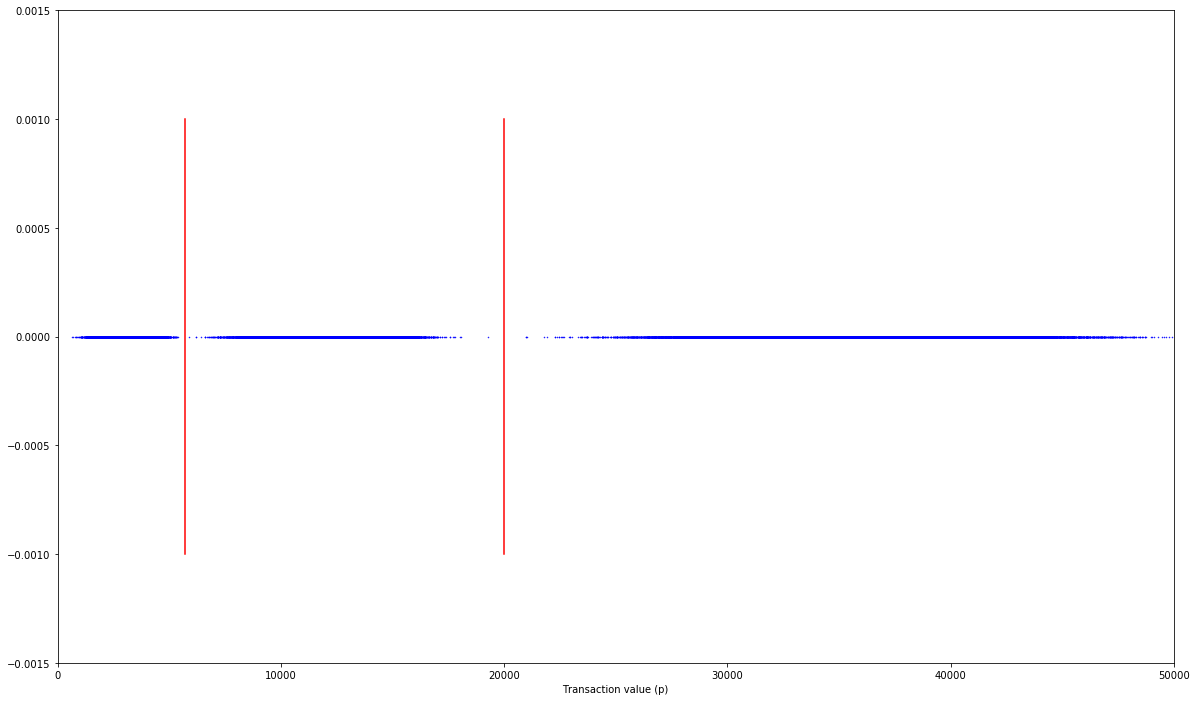

In [3]:
plt.scatter(list(train_data['transaction_value']), np.zeros(len(train_data['transaction_value'])), c='b', marker='.', s=1)
plt.plot([5700, 5700], [-0.001, 0.001], 'r')
plt.plot([20000, 20000], [-0.001, 0.001], 'r')
plt.axis([0, 50000, -0.0015, 0.0015])
plt.xlabel('Transaction value (p)')
# plt.savefig('Just transaction value.png', format='png')
plt.show()

The transaction value is clearly separated into three sections, separated by the red vertical lines in the above plot. They presumably represent different kinds of shopping.

The lowest price transactions are below £57 and the highest price transactions are above £200.

In [4]:
print('All price bands')
print('Max transaction value:', max(train_data['transaction_value']))
print('Min transaction value:', min(train_data['transaction_value']))
print('\nHigh price band')
print('Max transaction value:', max(train_data[train_data['transaction_value'] > 20000].transaction_value))
print('Min transaction value:', min(train_data[train_data['transaction_value'] > 20000].transaction_value))
print('Mean transaction value:', np.mean(train_data[train_data['transaction_value'] > 20000].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[train_data['transaction_value'] > 20000].transaction_value))
print('\nMiddle price band')
reduced_transaction_values = train_data[train_data['transaction_value'] < 20000].transaction_value
print('Max transaction value:', np.max(train_data[train_data[train_data['transaction_value'] < 20000]>5700].transaction_value))
print('Min transaction value:', np.min(train_data[train_data[train_data['transaction_value'] < 20000]>5700].transaction_value))
print('Mean transaction value:', np.mean(train_data[train_data[train_data['transaction_value'] < 20000]>5700].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[train_data[train_data['transaction_value'] < 20000]>5700].transaction_value))
print('\nLow price band')
print('Max transaction value:', max(train_data[train_data['transaction_value'] < 5700].transaction_value))
print('Min transaction value:', min(train_data[train_data['transaction_value'] < 5700].transaction_value))
print('Mean transaction value:', np.mean(train_data[train_data['transaction_value'] < 5700].transaction_value))
print('Standard deviation transaction value:', np.std(train_data[train_data['transaction_value'] < 5700].transaction_value))

All price bands
Max transaction value: 49903
Min transaction value: 651

High price band
Max transaction value: 49903
Min transaction value: 20986
Mean transaction value: 36039.156795921874
Standard deviation transaction value: 4107.434781404458

Middle price band
Max transaction value: 19289.0
Min transaction value: 5897.0
Mean transaction value: 11995.685903500473
Standard deviation transaction value: 1639.4275140500886

Low price band
Max transaction value: 5368
Min transaction value: 651
Mean transaction value: 3129.444782135773
Standard deviation transaction value: 676.2224422862612


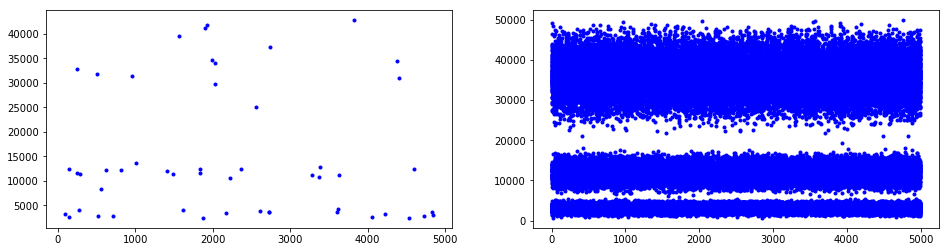

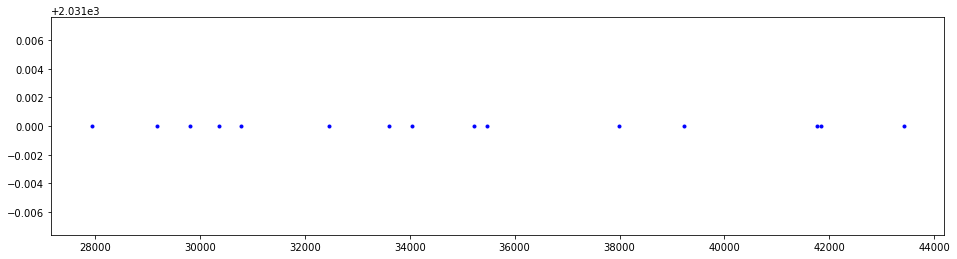

In [5]:
plt.rcParams['figure.figsize'] = (5, 3)
plt.figure(figsize=(16,4))
mt1 = plt.subplot(1,2,1) # Merchant id vs transaction value for the first 50 transactions
mt1.scatter(train_data['merchant_id'].loc[0:50], train_data['transaction_value'].loc[0:50], c='b', marker='.')
mt2 = plt.subplot(1,2,2) # Merchant id vs transaction value
mt2.scatter(train_data['merchant_id'], train_data['transaction_value'], c='b', marker='.')
plt.show()
plt.rcParams['figure.figsize'] = (16, 4)
plt.scatter(train_data[train_data['merchant_id']==train_data['merchant_id'].loc[6]].transaction_value, train_data[train_data['merchant_id']==train_data['merchant_id'].loc[6]].merchant_id, c='b', marker='.')
plt.show() # All transaction values for a single merchant
plt.rcParams['figure.figsize'] = (10, 6)

It is clear that the merchant ids are unordered, this means that it is difficult to visualise trends without further processing. However, having separated out a single merchant, it is worth noting that all of their transactions are in the high price band. How often is this the case?

In [6]:
"""Find out how many merchants make all transactions in a single band."""
count_merchants = 0
count_single_band_merchants = 0
for m in np.unique(train_data['merchant_id']):
    count_merchants +=1
    
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['merchant_id']==m].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
    # If two counts are 0, the merchant makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if all_low or all_mid or all_high:
        count_single_band_merchants +=1

print('Number of merchants:', count_merchants)
print('Number of merchants making all transactions in a single band:', count_single_band_merchants)
print('Proportion in a single band:', 100 * count_single_band_merchants / count_merchants)

Number of merchants: 5000
Number of merchants making all transactions in a single band: 4810
Proportion in a single band: 96.2


That proportion is quite high. This may provide useful information when searching for fraud.

In [7]:
"""Find out how many clients make all transactions in a single band."""
count_clients = 0
count_single_band_clients = 0
for m in np.unique(train_data['client_id']):
    count_clients +=1
    
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['client_id']==m].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if all_low or all_mid or all_high:
        count_single_band_clients +=1

print('Number of clients:', count_clients)
print('Number of clients making all transactions in a single band:', count_single_band_clients)
print('Proportion in a single band:', 100 * count_single_band_clients / count_clients)

Number of clients: 498
Number of clients making all transactions in a single band: 486
Proportion in a single band: 97.59036144578313


From this it is clear that using just transaction value will not be enough to find the 10 fraudulent transactions. However, this could be a useful as a filter if other methods are not sufficient.

In [8]:
"""One-hot encode the ids"""
# One-hot encode merchant_id and client_id
print(train_data[train_data['date']==0])
enc_train_data = pd.get_dummies(train_data, columns=['merchant_id', 'client_id'], sparse=True) # Sparse should make data storage more efficient
print(enc_train_data)

      transaction_id  client_id  transaction_value  merchant_id  date   time  \
0                  1        340              29756         2023     0     22   
1                  2        227               3318           84     0     66   
2                  3        430              12191          814     0    128   
3                  4        142               2884          510     0    197   
4                  5        452              34639         1993     0    242   
5                  6        478              11941         1407     0    291   
6                  7        232              34050         2031     0    323   
7                  8        270              32764          246     0    390   
8                  9        204               3295         4227     0    432   
9                 10        199               2549         4057     0    474   
10                11         72              11244         3632     0    548   
11                12        276         

<h3>Looking at the other features of the data</h3>

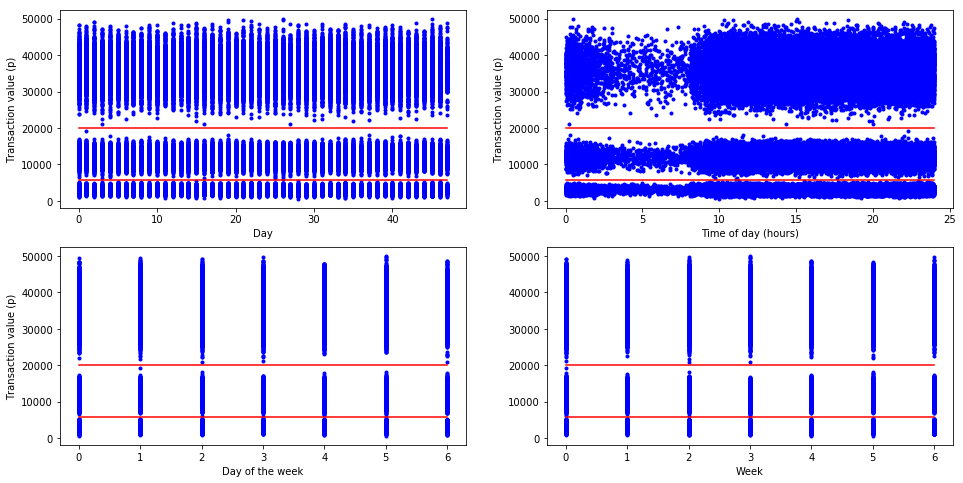

In [9]:
plt.figure(figsize=(16,8))
dt = plt.subplot(2,2,1)
dt.scatter(enc_train_data['date'], enc_train_data['transaction_value'], c='b', marker='.')
dt.plot([0,47], [5700, 5700], 'r')
dt.plot([0,47], [20000, 20000], 'r')
dt.set_xlabel('Day')
dt.set_ylabel('Transaction value (p)')

tt = plt.subplot(2,2,2)
tt.scatter(enc_train_data['time']/3600, enc_train_data['transaction_value'], c='b', marker='.')
tt.plot([0,24], [5700, 5700], 'r')
tt.plot([0,24], [20000, 20000], 'r')
tt.set_xlabel('Time of day (hours)')
tt.set_ylabel('Transaction value (p)')

dwt = plt.subplot(2,2,3)
dwt.scatter(enc_train_data['date']%7, enc_train_data['transaction_value'], c='b', marker='.')
dwt.plot([0,6], [5700, 5700], 'r')
dwt.plot([0,6], [20000, 20000], 'r')
dwt.set_xlabel('Day of the week')
dwt.set_ylabel('Transaction value (p)')

wt = plt.subplot(2,2,4)
# converting to integer automatically rounds down
wt.scatter((enc_train_data['date']/7).astype(int), enc_train_data['transaction_value'], c='b', marker='.')
wt.plot([0,6], [5700, 5700], 'r')
wt.plot([0,6], [20000, 20000], 'r')
wt.set_xlabel('Week')
wt.set_label('Transaction value (p)')
plt.show()

At a macro level (where micro would look at specific clients or merchants), there seems to be no correlation between time and transaction value.

The only visible feature is the drop in transaction rate between 2 and 7 in the morning.

Also, having looked at the transaction values closely, the transaction with a value just below £200 seems out of place. This could either be because it belongs in the higher price band or because it is fraudulent.

In [10]:
lowmid_price_band_data = train_data[train_data['transaction_value'] < 20000]
print(max(lowmid_price_band_data['transaction_value']))
print(train_data[train_data['transaction_value'] == 19289])

19289
      transaction_id  client_id  transaction_value  merchant_id  date   time  \
3998            3999        269              19289         3939     1  80334   

      fraud_flag  
3998           0  


It clearly isn't fraudulent. However, now I know that that isn't a worthwhile line of enquiry.

In [11]:
cluster_train_data_columns = list(enc_train_data.columns.values)
cluster_train_data_columns = cluster_train_data_columns[1:4]

cluster_train_data = enc_train_data[enc_train_data['client_id_357']==1]

cluster_train_data = cluster_train_data[cluster_train_data_columns]

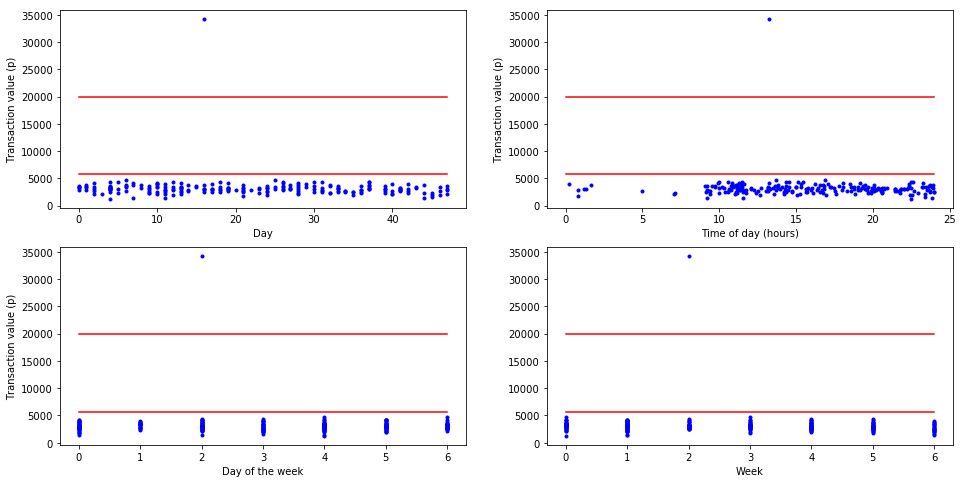

In [12]:
plt.figure(figsize=(16,8))
dt = plt.subplot(2,2,1)
dt.scatter(cluster_train_data['date'], cluster_train_data['transaction_value'], c='b', marker='.')
dt.plot([0,47], [5700, 5700], 'r')
dt.plot([0,47], [20000, 20000], 'r')
dt.set_xlabel('Day')
dt.set_ylabel('Transaction value (p)')

tt = plt.subplot(2,2,2)
tt.scatter(cluster_train_data['time']/3600, cluster_train_data['transaction_value'], c='b', marker='.')
tt.plot([0,24], [5700, 5700], 'r')
tt.plot([0,24], [20000, 20000], 'r')
tt.set_xlabel('Time of day (hours)')
tt.set_ylabel('Transaction value (p)')

dwt = plt.subplot(2,2,3)
dwt.scatter(cluster_train_data['date']%7, cluster_train_data['transaction_value'], c='b', marker='.')
dwt.plot([0,6], [5700, 5700], 'r')
dwt.plot([0,6], [20000, 20000], 'r')
dwt.set_xlabel('Day of the week')
dwt.set_ylabel('Transaction value (p)')

wt = plt.subplot(2,2,4)
# converting to integer automatically rounds down
wt.scatter((cluster_train_data['date']/7).astype(int), cluster_train_data['transaction_value'], c='b', marker='.')
wt.plot([0,6], [5700, 5700], 'r')
wt.plot([0,6], [20000, 20000], 'r')
wt.set_xlabel('Week')
wt.set_label('Transaction value (p)')
plt.show()

<h2>Clustering</h2>

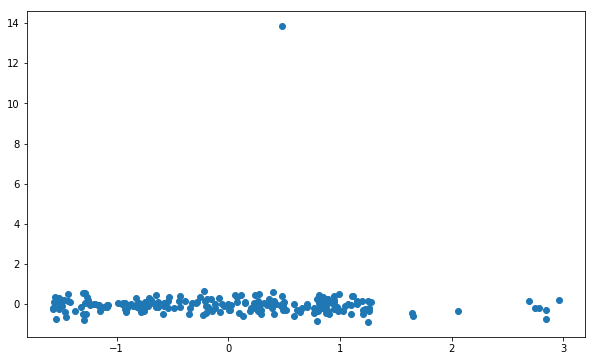

In [13]:
pca = PCA(n_components=2, whiten=True)
pca_cluster_train_data = pca.fit_transform(cluster_train_data)

plt.scatter(pca_cluster_train_data[:,0], pca_cluster_train_data[:,1])

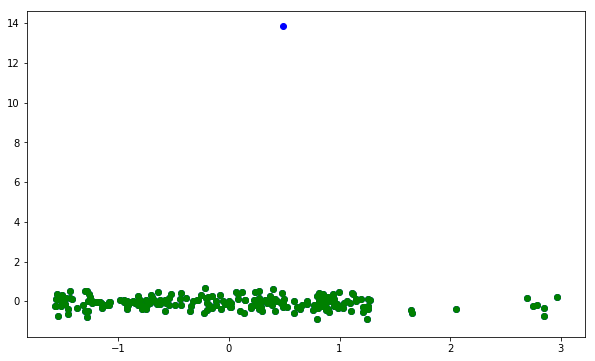

In [14]:
clustered_pca_train= KMeans(n_clusters=2).fit(pca_cluster_train_data)

plt.scatter(pca_cluster_train_data[:,0], pca_cluster_train_data[:,1], c='b')
outlier = pca_cluster_train_data[clustered_pca_train.labels_==0]
plt.scatter(outlier[:,0], outlier[:,1], c='g')

In [15]:
count_labelled = (len(pca_cluster_train_data[clustered_pca_train.labels_==0]), len(pca_cluster_train_data[clustered_pca_train.labels_==1]))
print(count_labelled)
print((cluster_train_data[pca_cluster_train_data==pca_cluster_train_data[clustered_pca_train.labels_ == np.argmin(count_labelled)]]).index[0] + 1)

(211, 1)
34543


199
161


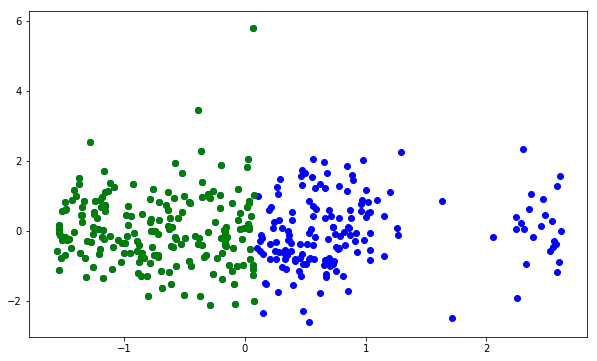

151
183
26


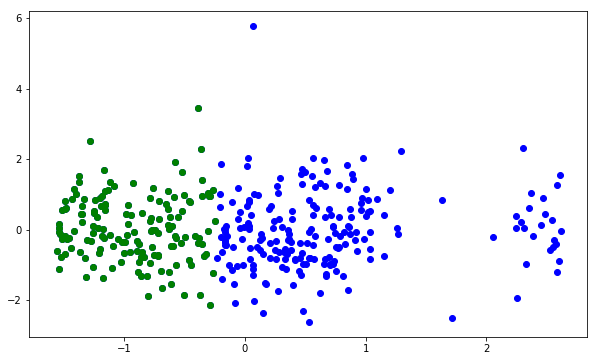

104
121
26
109


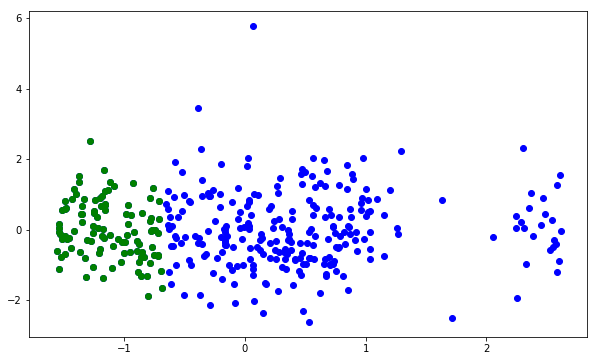

93
26
74
92
75


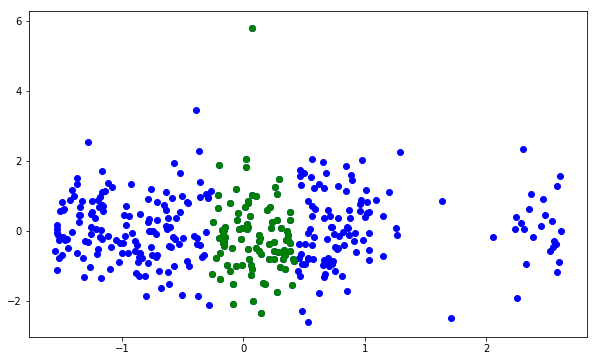

67
74
26
64
63
66


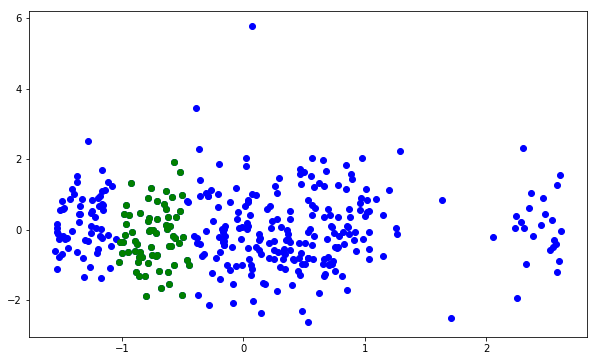

63
57
60
25
69
21
65


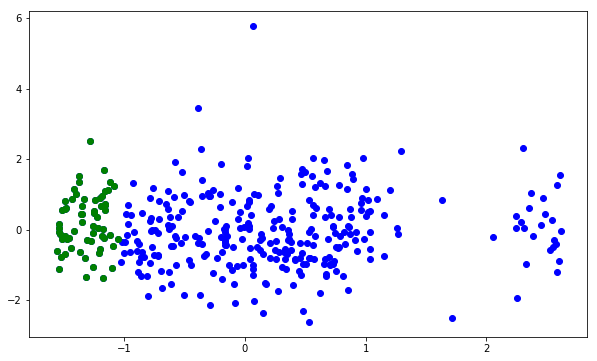

34
63
25
52
50
63
49
24


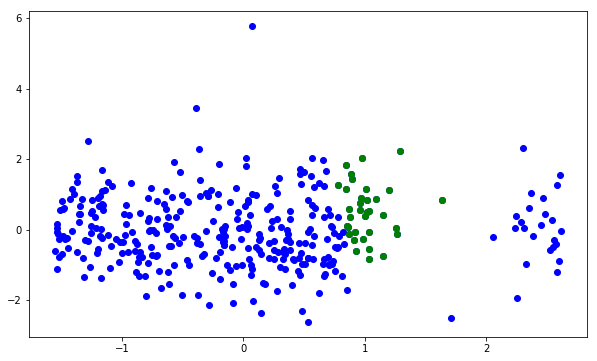

63
41
25
25
22
50
57
35
42


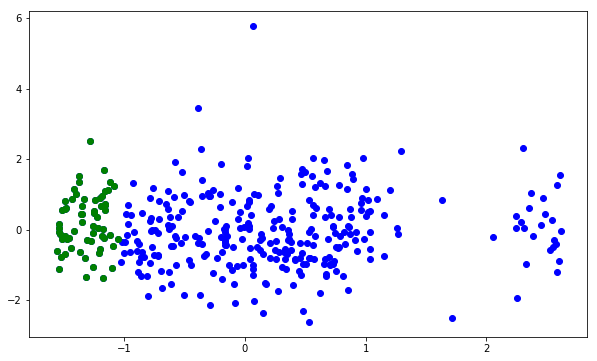

35
42
25
23
60
44
27
44
22
38


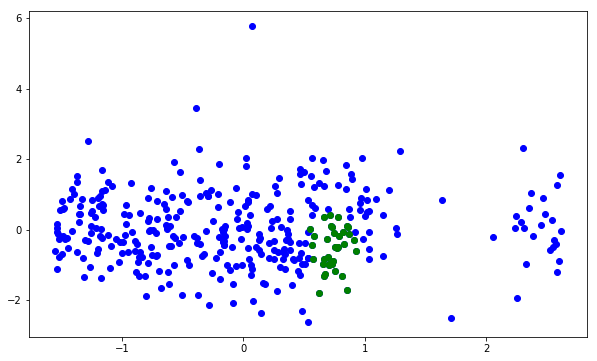

39
29
25
26
24
35
45
35
34
31
37


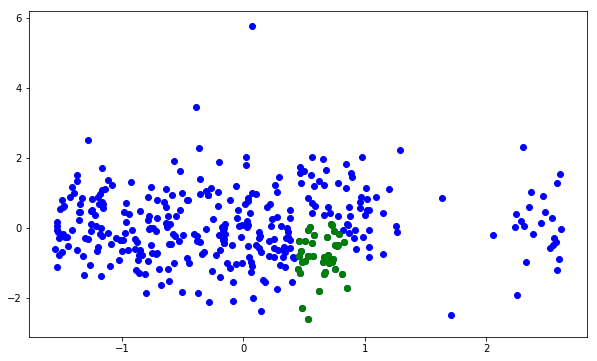

42
25
37
24
23
34
28
36
30
33
31
17


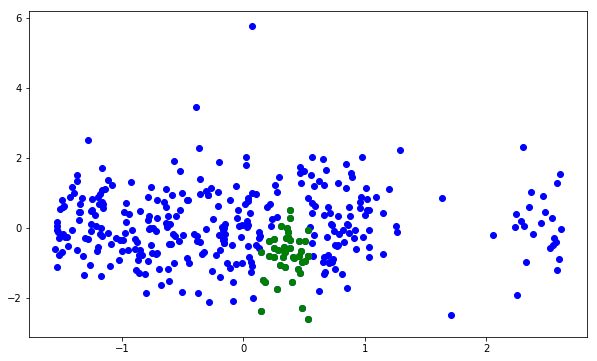

33
4
37
34
29
39
34
28
33
20
21
32
16


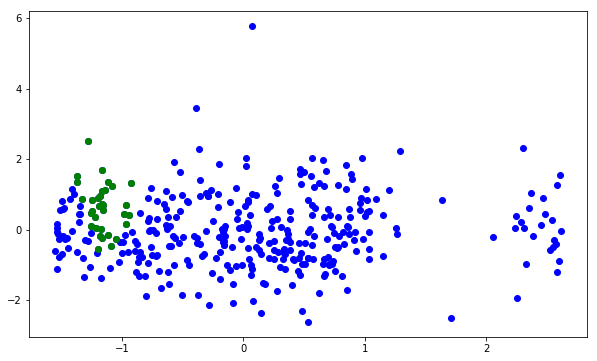

27
42
24
29
8
32
21
32
40
32
15
34
22
2


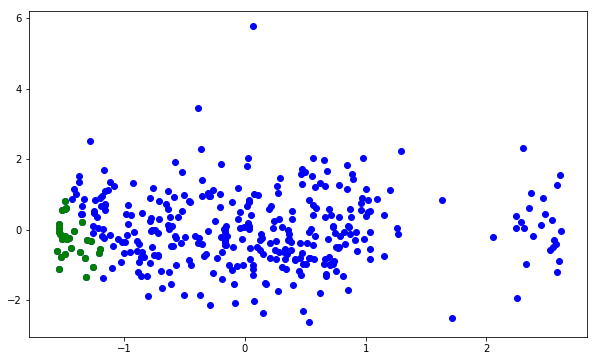

20
25
4
20
29
28
30
28
21
29
37
31
4
22
32


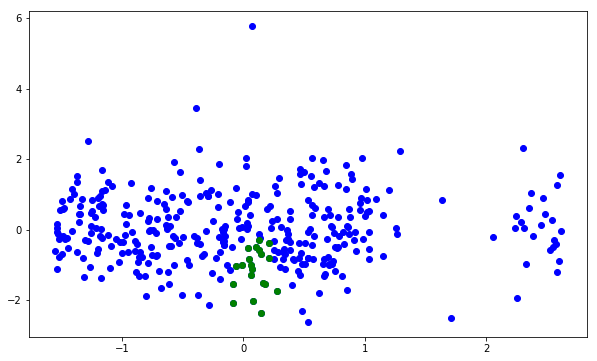

29
24
35
24
35
23
21
24
24
16
29
19
1
31
1
24


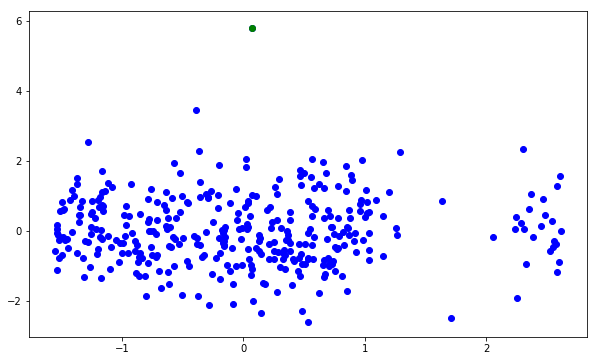

30
33
12
26
31
39
18
20
19
5
15
12
25
31
23
1
20


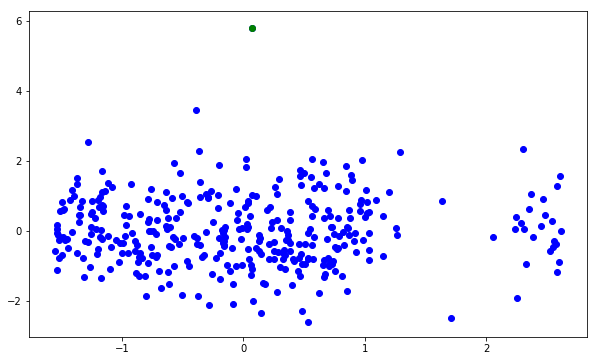

25
19
15
25
30
21
21
39
13
27
1
19
23
20
2
22
29
9


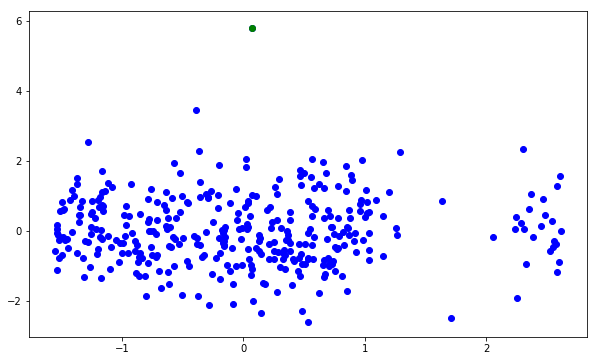

33
33
15
14
16
27
25
20
5
17
24
16
19
10
17
14
19
1
35


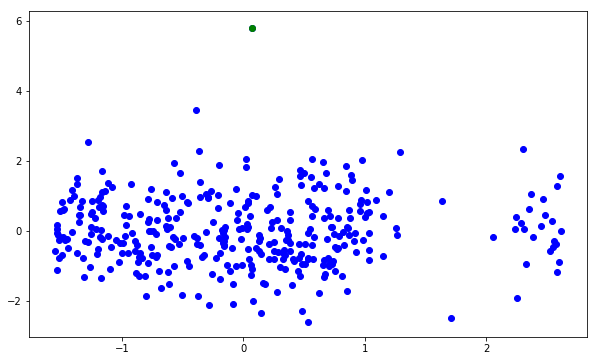

[50831, 34740, 34740, 34740, 34740]
[34740 50831]
34740


In [19]:
"""This is probably the best place to see how Cluster filtering works"""

cluster_train_data = enc_train_data[enc_train_data['client_id_263']==1]

outlier_ids = []
for i in range(2, 20):
    clustered_train = KMeans(n_clusters=i, n_init=20).fit(cluster_train_data[cluster_train_data_columns])
    
    out_label = 0
    for j in range(i):
        print(len(clustered_train.labels_[clustered_train.labels_==j]))
        if len(clustered_train.labels_[clustered_train.labels_==j]) == 1:
            out_label = j
            outlier_id = cluster_train_data[clustered_train.labels_==j].transaction_id
            outlier_ids.append(outlier_id.values[0])
    
    pca = PCA(n_components=2, whiten=True)
    pca_clustered_train = pca.fit_transform(cluster_train_data[cluster_train_data_columns])
    
    pca_plt = plt.subplot(1, 1, 1)
    plt.scatter(pca_clustered_train[:,0], pca_clustered_train[:,1], c='b')
    outlier = pca_clustered_train[clustered_train.labels_==out_label]
    plt.scatter(outlier[:,0], outlier[:,1], c='g')
    plt.show()

print(outlier_ids)
print(np.unique(outlier_ids))

my_outlier = max(list(np.unique(outlier_ids)), key=list(np.unique(outlier_ids)).count)
print(my_outlier)

In [17]:
"""Normalise the values in the encoded training data"""
"""    This didn't end up being useful, I've left it in for posterity,
        with a note that sklearn.preprocessing.scale may have been better"""
print(enc_train_data.columns)

print(list(enc_train_data.columns[1:4]))

norm_train_columns = list(enc_train_data.columns.values)
norm_train_columns = norm_train_columns[:4] + norm_train_columns[5005:]

norm_train_data = enc_train_data[norm_train_columns].copy()
norm_train_data['transaction_value'] = norm_train_data['transaction_value'] / max(norm_train_data['transaction_value'])
## Do I want to use day of week (and maybe week) rather than pure date?
norm_train_data['date'] = norm_train_data['date'] / max(norm_train_data['date'])
norm_train_data['time'] = norm_train_data['time'] / max(norm_train_data['time'])
print(max(norm_train_data.transaction_value), max(norm_train_data.date), max(norm_train_data.time))
#print(norm_train_data.columns.values)

Index(['transaction_id', 'transaction_value', 'date', 'time', 'fraud_flag',
       'merchant_id_0', 'merchant_id_1', 'merchant_id_2', 'merchant_id_3',
       'merchant_id_4',
       ...
       'client_id_488', 'client_id_489', 'client_id_490', 'client_id_491',
       'client_id_492', 'client_id_493', 'client_id_494', 'client_id_495',
       'client_id_496', 'client_id_497'],
      dtype='object', length=5503)
['transaction_value', 'date', 'time']
1.0 1.0 1.0


In [27]:
"""Use clustering to find unusual transactions for a given client"""

print(len(enc_train_data.columns))
print(len(norm_train_data.columns))
fraudulent_transactions = []
for c in range(4, len(norm_train_data.columns)): 
    # Show how far through the code is
    if c%20 == 0:
        print(c)
    
    ctd_w_id = enc_train_data[enc_train_data[norm_train_data.columns[c]]==1] #357, 263 
    cluster_train_data = ctd_w_id[ctd_w_id.columns.values[1:4]]
    
    
    outlier_ids = []
    for i in range(2, 20):
        if len(cluster_train_data) < i:
            continue
        
        clustered_train = KMeans(n_clusters=i, n_init=20).fit(cluster_train_data)

        out_label = 0
        for j in range(i):
            if len(clustered_train.labels_[clustered_train.labels_==j]) == 1:
                out_label = j
                outlier_id = ctd_w_id[clustered_train.labels_==j].transaction_id
                outlier_ids.append(outlier_id.values[0])

    my_outliers = list(np.unique(outlier_ids))
    if len(my_outliers) > 0:
        my_outlier = max(list(np.unique(outlier_ids)), key=list(np.unique(outlier_ids)).count)
        fraudulent_transactions.append((c-4, my_outlier))
print(fraudulent_transactions)

5503
502
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
[(0, 1255), (2, 1468), (3, 14754), (4, 17753), (5, 42112), (6, 5199), (7, 9337), (8, 3133), (9, 4547), (10, 1636), (11, 7905), (12, 596), (13, 4925), (14, 4260), (15, 2983), (16, 1276), (17, 3997), (18, 5209), (19, 7950), (20, 497), (21, 4215), (22, 37257), (23, 342), (24, 12684), (25, 5712), (26, 4109), (27, 31705), (28, 27273), (29, 31701), (30, 40705), (31, 8731), (32, 118), (33, 2218), (34, 13648), (35, 27827), (36, 46139), (37, 6278), (38, 87), (39, 17650), (40, 8420), (41, 19211), (42, 93101), (43, 2121), (44, 6367), (45, 2228), (46, 10699), (47, 48476), (48, 31818), (49, 71971), (50, 48680), (51, 84612), (52, 67228), (53, 10688), (54, 65642), (55, 21227), (57, 59275), (58, 30341), (60, 19172), (62, 80387), (63, 27594), (64, 2155), (65, 6422), (67, 1822), (68, 25491), (70, 55059), (71, 89862), (72, 36062), (73, 69869), (74, 38138), (75, 33950), (76, 48734), (78, 38181), (79, 8

In [20]:
count_multi_band_clients = 0
multi_band_fraud = []
for c_id, transaction_no in fraudulent_transactions:
    # Count which clients labelled as having fraudulent transactions are in a single band
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['client_id']==c_id].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if not(all_low or all_mid or all_high):
        count_multi_band_clients +=1
        multi_band_fraud.append((c_id, transaction_no, count_low, count_mid, count_high))

print(count_multi_band_clients)
print(multi_band_fraud)

11
[(47, 41355, 85, 1, 0), (52, 67228, 0, 1, 77), (120, 51558, 0, 1, 184), (171, 42283, 0, 1, 283), (175, 40298, 258, 1, 0), (191, 39108, 1, 296, 0), (248, 53168, 1, 351, 0), (263, 34740, 0, 1, 359), (269, 3999, 0, 1, 381), (357, 34543, 211, 0, 1), (496, 6213, 2, 0, 1)]


From a manual check, the above managed to catch 9 out of the 10 fraudulent transactions.

Transaction 40298 was a false positive, and transaction 40667 (client_id=175) was missed. Interestingly, this does at least mean that all of the correct clients were picked!

Since this method of filtering was fairly effective, I will apply this first and see what I can learn.

In [21]:
count_multi_band_clients = 0
multi_band_fraud = []
for c_id in range(498):
    # Count which clients labelled as having fraudulent transactions are in a single band
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in train_data[train_data['client_id']==c_id].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 5700:
            count_low+=1
        else:
            count_mid+=1
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if not(all_low or all_mid or all_high):
        count_multi_band_clients +=1
        multi_band_fraud.append((c_id, count_low, count_mid, count_high))
print(count_multi_band_clients)
print(multi_band_fraud)

12
[(47, 85, 1, 0), (52, 0, 1, 77), (120, 0, 1, 184), (171, 0, 1, 283), (175, 258, 1, 0), (191, 1, 296, 0), (248, 1, 351, 0), (263, 0, 1, 359), (264, 1, 398, 0), (269, 0, 1, 381), (357, 211, 0, 1), (496, 2, 0, 1)]


The most striking thing is that all clients with fraudulent transactions are found in this list.

I therefore think that the best method will be to use this filter then put the remaining clients through the clustering filter. The flagged transactions from there will considered most likely fraudulent transactions. I will then attempt to determine by eye the remaining fraudulent transactions using PCA.

This will not help me catch false positives like transaction 40298 but in the real world I would prefer to overestimate the number of fraudulent transactions than miss some.

<h2>Test set</h2>

In [22]:
test_data_cols = ['transaction_id', 'client_id', 'transaction_value', 'merchant_id', 'date', 'time']
test_data = pd.read_csv('transaction_two_base.csv', names=train_data_cols)
test_data.shape

(100000, 7)

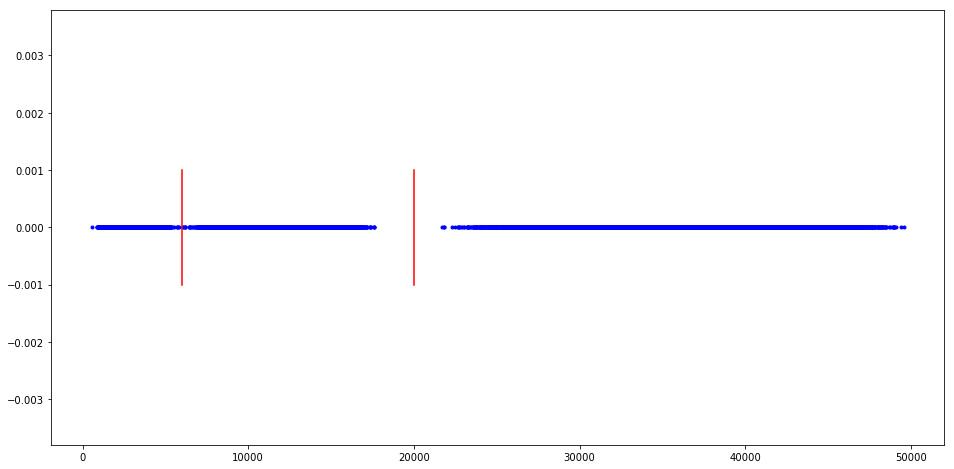

In [23]:
plt.figure(figsize=(16,8))
plt.scatter(list(test_data['transaction_value']), np.zeros(len(test_data['transaction_value'])), c='b', marker='.')
plt.plot([6000, 6000], [-0.001, 0.001], 'r')
plt.plot([20000, 20000], [-0.001, 0.001], 'r')
plt.show()

In [24]:
"""Filter out clients who always buy in a single band
        This is referred to in text as PRICE FILTERING"""
count_clients = 0
count_multi_band_clients = 0
multi_band_clients = []
for c_id in np.unique(test_data['client_id']):
    count_clients +=1
    # Count which clients labelled as having fraudulent transactions are in a single band
    count_low = 0
    count_mid = 0
    count_high = 0
    for t in test_data[test_data['client_id']==c_id].transaction_value:
        if t > 20000:
            count_high+=1
        elif t < 6000:
            count_low+=1
        else:
            count_mid+=1
    # If two counts are 0, the client makes all transactions in a single band
    all_high = (count_mid==0) and (count_low==0)
    all_mid = (count_high==0) and (count_low==0)
    all_low = (count_mid==0) and (count_high==0)
    if not(all_low or all_mid or all_high):
        count_multi_band_clients +=1
        multi_band_clients.append((c_id, count_low, count_mid, count_high))

print(count_clients)        
print(count_multi_band_clients)
print(multi_band_clients)

499
12
[(11, 24, 0, 1), (28, 1, 1, 44), (93, 123, 1, 0), (131, 0, 1, 232), (151, 1, 287, 0), (183, 1, 319, 0), (247, 0, 1, 383), (266, 1, 395, 0), (325, 0, 281, 1), (385, 0, 1, 179), (412, 1, 130, 0), (414, 124, 0, 1)]


Given the spread between the outlier transaction and the others, I am already confident that the clients 11 and 414 have fraudulent transactions.

The cluster filtering should tell me what those fraudulent transactions are.

In [25]:
"""Use clustering to find unusual transactions for the filtered list of clients
        This is referred to in markdown as CLUSTER FILTERING"""

fraudulent_transactions = []
for c in np.array(multi_band_clients)[:,0]: #client id
    # Show how far through the code is
    print(c)
    
    filtered_data = test_data[test_data.client_id == c]
    # Use column names since I haven't used one-hot encoding
    cluster_train_data = filtered_data[['transaction_value', 'date', 'time']]
    
    outlier_ids = []
    for i in range(2, 20): # Number of clusters
        if len(cluster_train_data) < i:
            continue
        
        clustered_train = KMeans(n_clusters=i, n_init=20).fit(cluster_train_data)

        for j in range(i):
            if len(clustered_train.labels_[clustered_train.labels_==j]) == 1:
                outlier_id = filtered_data[clustered_train.labels_==j].transaction_id
                outlier_ids.append(outlier_id.values[0])

    my_outliers = list(np.unique(outlier_ids))
    if len(my_outliers) > 0:
        my_outlier = max(list(np.unique(outlier_ids)), key=list(np.unique(outlier_ids)).count)
        fraudulent_transactions.append((c, my_outlier))

print(fraudulent_transactions)
print(len(fraudulent_transactions))

11
28
93
131
151
183
247
266
325
385
412
414
[(11, 9071), (28, 42323), (93, 73969), (131, 21605), (247, 26235), (266, 75009), (325, 93974), (385, 28475), (412, 21165), (414, 38820)]
10
